<a href="https://colab.research.google.com/github/Praveendwivedi/VehicleRoutingProblem/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Praveendwivedi/VehicleRoutingProblem.git

Cloning into 'VehicleRoutingProblem'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 79 (delta 25), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (79/79), done.


In [ ]:
%cd VehicleRoutingProblem/

/content/VehicleRoutingProblem/VehicleRoutingProblem/VehicleRoutingProblem/VehicleRoutingProblem


In [ ]:
!pip install -r requirements

# **load sample data**

In [ ]:
import  pandas as pd
data=pd.read_csv('clustering-algos/samplelocds.csv')
Y=data['Latitude']
X=data['Longitude']
data.head()
input_data=[[X[i],Y[i]] for i in range(len(X))]


visualize data

[]

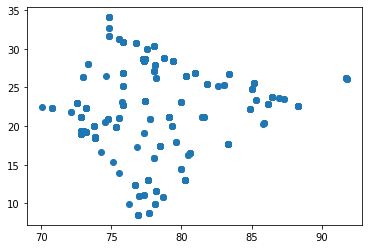

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(X, Y)
plt.plot()

In [ ]:
import folium 
my_map3 = folium.Map(location = [28.5011226, 77.4099794],
                                        zoom_start = 4)
for i in input_data:
  folium.Marker(i[::-1]).add_to(my_map3)
my_map3



# **Clustering**

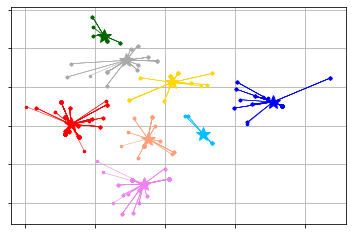

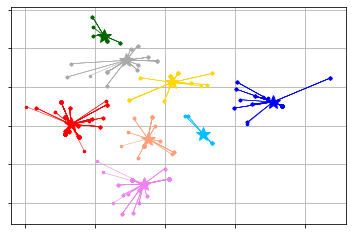

In [ ]:
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample

# Load list of points for cluster analysis.
# sample = read_sample(FCPS_SAMPLES.SAMPLE_LSUN)

# Prepare initial centers using K-Means++ method.
initial_centers = kmeans_plusplus_initializer(input_data, 8).initialize()

# Create instance of K-Means algorithm with prepared centers.
kmeans_instance = kmeans(input_data, initial_centers)

# Run cluster analysis and obtain results.
kmeans_instance.process()
clusters = kmeans_instance.get_clusters()
final_centers = kmeans_instance.get_centers()

# Visualize obtained results
kmeans_visualizer.show_clusters(input_data, clusters, final_centers)



get list of datapoints from each cluster

In [ ]:
n_cluster = len(clusters)
print(n_cluster)
loc_set=[]
for cluster in clusters:
  loc_set.append(list(map(lambda i : input_data[i][::-1], cluster)) )
print(loc_set)

8
[[[18.9667, 72.8333], [22.7206, 75.8472], [18.5196, 73.8553], [18.5196, 73.8553], [19.2502, 73.1602], [18.9667, 72.8333], [18.9667, 72.8333], [20.55, 74.55], [18.9667, 72.8333], [20.0, 73.7833], [20.9, 74.7833], [21.765, 72.1369], [18.9667, 72.8333], [18.5196, 73.8553], [19.2167, 73.15], [21.17, 72.83], [18.5196, 73.8553], [23.03, 72.58], [23.03, 72.58], [20.0, 73.7833], [20.9, 74.7833], [19.18, 72.9633], [18.9667, 72.8333], [18.5196, 73.8553], [18.9667, 72.8333], [18.9667, 72.8333], [20.0, 73.7833], [18.9667, 72.8333], [18.9667, 72.8333], [19.88, 75.32], [18.6278, 73.8131], [21.17, 72.83], [21.17, 72.83], [22.3, 73.2], [18.9667, 72.8333], [18.5196, 73.8553], [23.03, 72.58], [18.5196, 73.8553], [23.03, 72.58], [18.9667, 72.8333], [21.0167, 75.5667], [18.9667, 72.8333], [22.2969, 70.7984], [18.9667, 72.8333], [21.17, 72.83], [22.3, 73.2], [18.9667, 72.8333], [18.9667, 72.8333], [20.9, 74.7833], [18.9667, 72.8333], [18.5196, 73.8553], [16.7, 74.2333], [23.03, 72.58], [18.9667, 72.8333]

In [ ]:
my_map = folium.Map(location = [28.5011226, 77.4099794],
                                        zoom_start = 4)
for i in loc_set[0]:
  folium.Marker(i).add_to(my_map)
  # print(i)
my_map

# **VRP**

create distance matrix

In [92]:
from ortools.constraint_solver import routing_enums_pb2 
from ortools.constraint_solver import pywrapcp
from random import randint
mat=[[0 for _ in range(len(loc_set[0]))]for _ in range(len(loc_set[0]))]
from geopy import distance
for i in range(0,len(loc_set[0])): 
  for j in range(i+1,len(loc_set[0])): 
    mat[i][j]=int(distance.distance(loc_set[0][i],loc_set[0][j]).km) 
    mat[j][i]=mat[i][j]
print(mat[i])
print(mat[0][99])

def create_data_model(): 
  data={} 
  data['distance_matrix'] = mat 
  data['demands'] = [0]+[randint(1,4) for _ in range(len(loc_set[0])-1)] 
  data['vehicle_capacities'] = [30]*50 
  print('load:', sum(data['demands'])) 
  data['num_vehicles'] = 50 
  data['depot'] = 0 
  return data

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))




[118, 509, 0, 0, 109, 118, 118, 236, 118, 164, 280, 401, 118, 0, 107, 312, 0, 516, 516, 164, 280, 119, 118, 0, 118, 118, 164, 118, 118, 215, 12, 312, 312, 424, 118, 0, 516, 0, 516, 118, 329, 118, 525, 118, 312, 424, 118, 118, 280, 118, 0, 205, 516, 118, 109, 312, 118, 118, 236, 118, 215, 312, 312, 516, 118, 589, 118, 553, 280, 118, 516, 118, 0, 0, 118, 329, 118, 118, 118, 424, 312, 109, 516, 312, 0, 118, 509, 0, 280, 118, 118, 118, 516, 516, 0, 0, 424, 312, 118, 118, 118, 312, 0, 312, 516, 312, 118, 118, 509, 516, 516, 0, 118, 516, 118, 0, 0, 118, 215, 109, 118, 509, 107, 118, 118, 12, 118, 118, 118, 312, 516, 118, 118, 516, 136, 509, 118, 164, 509, 164, 424, 119, 118, 119, 12, 312, 0, 509, 118, 118, 0, 0, 12, 312, 164, 118, 424, 119, 136, 516, 118, 215, 329, 118, 118, 12, 401, 118, 312, 0, 118, 516, 0, 136, 509, 516, 0, 118, 118, 118, 312, 109, 136, 118, 118, 215, 118, 118, 516, 516, 118, 424, 118, 280, 215, 118, 509, 118, 118, 509, 0, 12, 118, 312, 516, 509, 516, 109, 516, 312, 0, 11

In [93]:
def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.FromSeconds(1)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


if __name__ == '__main__':
    main()

load: 701
Objective: 10401
Route for vehicle 0:
 0 Load(0) ->  0 Load(0)
Distance of the route: 0m
Load of the route: 0

Route for vehicle 1:
 0 Load(0) ->  0 Load(0)
Distance of the route: 0m
Load of the route: 0

Route for vehicle 2:
 0 Load(0) ->  0 Load(0)
Distance of the route: 0m
Load of the route: 0

Route for vehicle 3:
 0 Load(0) ->  0 Load(0)
Distance of the route: 0m
Load of the route: 0

Route for vehicle 4:
 0 Load(0) ->  0 Load(0)
Distance of the route: 0m
Load of the route: 0

Route for vehicle 5:
 0 Load(0) ->  0 Load(0)
Distance of the route: 0m
Load of the route: 0

Route for vehicle 6:
 0 Load(0) ->  0 Load(0)
Distance of the route: 0m
Load of the route: 0

Route for vehicle 7:
 0 Load(0) ->  0 Load(0)
Distance of the route: 0m
Load of the route: 0

Route for vehicle 8:
 0 Load(0) ->  0 Load(0)
Distance of the route: 0m
Load of the route: 0

Route for vehicle 9:
 0 Load(0) ->  0 Load(0)
Distance of the route: 0m
Load of the route: 0

Route for vehicle 10:
 0 Load(0) 